In [1]:
import pandas as pd
import numpy as np
import torch
import random

# dataloader
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

from sys_model_dataset import  SysModelDataset

# Import pytorch_lightning model
import pytorch_lightning as pl
from system_model import SysModel

# make jupytre relode modules when they change
%load_ext autoreload
%autoreload 2

# Load dataset

In [2]:
# csv file path
df = pd.read_csv('../../../../misc/recorded_data/tick_based_100hz_23-02-19.csv')

In [3]:

"""
From tick_based_100hz_23-02-19.csv we get:
    input_channel_means [5.867484 5.720537]
    input_channel_stds [4.866541  4.8768854]
    output_channel_means 1619.3425
    output_channel_stds 158.12558
    internal_channel_means [-2.0340237e+03  6.3358569e-01 -2.1668540e+03  1.4289156e+01]
    internal_channel_stds [1.1323308e+03 1.1938887e+00 1.2715853e+03 1.0630209e+00]
"""

train_df = df[:int(len(df)*0.8)]
val_df = df[int(len(df)*0.8):]

# Create dataset
train_dataset = SysModelDataset(
    df=train_df,
    num_time_steps_before=30,
    num_time_steps_after=1,
)

val_dataset = SysModelDataset(
    df=val_df,
    num_time_steps_before=30,
    num_time_steps_after=1
)



### Insepct data

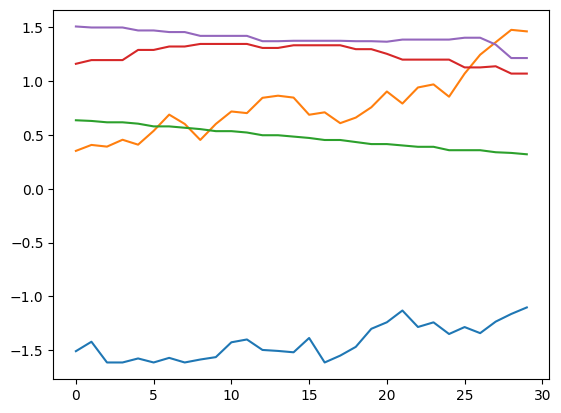

In [4]:
past_inputs, past_outputs, past_interals, future_inputs, future_outputs, future_interals = train_dataset[random.randint(0, len(train_dataset))]


# plot past
for i in range(past_inputs.shape[0]):
    plt.plot(past_inputs[i, :].numpy())
for i in range(past_outputs.shape[0]):
    plt.plot(past_outputs[i, :].numpy())
for i in range(past_interals.shape[0]):
    plt.plot(past_interals[i, :].numpy())

# Train sys model

In [14]:
sys_model = SysModel(
    num_past_time_steps = 30,
    num_input_vars = 2,
    num_output_vars = 1,
    num_internal_vars = 4,
)

In [ ]:
# Create dataloader
dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=8)

In [ ]:
# train model. log interval is set to 1
trainer = pl.Trainer(max_epochs=1, gpus=1)
trainer.fit(sys_model, dataloader)

In [39]:
# save model
import datetime
now = datetime.datetime.now()
torch.save(sys_model.state_dict(), 'sys_model_{}.pt'.format(now.strftime("%Y-%m-%d_%H-%M-%S")))

# Evaluate sys model

In [4]:
# load model
sys_model = SysModel(
    num_past_time_steps = 30,
    num_input_vars = 2,
    num_output_vars = 1,
    num_internal_vars = 4,
)
sys_model.load_state_dict(torch.load('./sys_model_2023-02-22_15-19-49.pt'))

<All keys matched successfully>

### MSE of the model on the validation set

In [ ]:
def test_performance_of_model(sys_model, val_dataset):
    # Calculate the mean MSE of the model on the validation set
    dataloader = DataLoader(val_dataset, batch_size=20, shuffle=True, num_workers=8)
    mean_mse = 0
    for past_inputs, past_outputs, past_interals, future_inputs, future_outputs, future_interals in dataloader:
        next_predicted_output, next_predicted_internal = sys_model(past_inputs, past_outputs, past_interals)
        mse = torch.mean((next_predicted_output - future_outputs)**2 + (next_predicted_internal - future_interals)**2)
        mean_mse += mse
    mean_mse /= len(dataloader)
    return mean_mse

In [ ]:
# Test the performance of the model
test_performance_of_model(sys_model, val_dataset)
# tensor(0.0016, grad_fn=<DivBackward0>)
# tensor(0.0009, grad_fn=<DivBackward0>)
# tensor(0.0008, grad_fn=<DivBackward0>)

### Predict future

In [5]:
ar_dataset = SysModelDataset(
    df=train_df,
    num_time_steps_before=30,
    num_time_steps_after=100
)

In [6]:
# Create dataloader
ar_dataloader = DataLoader(ar_dataset, batch_size=1, shuffle=True, num_workers=8)

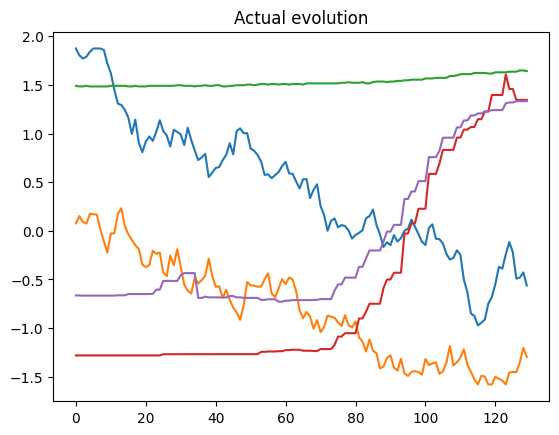

RuntimeError: Given groups=1, weight of size [10, 5, 3], expected input[1, 3, 30] to have 5 channels, but got 3 channels instead

In [7]:
# Get a batch
past_inputs, past_outputs, past_interals, future_inputs, future_outputs, future_interals = next(iter(ar_dataloader))

inputs = torch.cat((past_inputs, future_inputs), dim=2)
outputs = torch.cat((past_outputs, future_outputs), dim=2)
interals = torch.cat((past_interals, future_interals), dim=2)


# Plot base truth
for i in range(inputs.shape[1]):
    plt.plot(inputs[0, i, :].numpy())
for i in range(outputs.shape[1]):
    plt.plot(outputs[0, i, :].numpy())
for i in range(interals.shape[1]):
    plt.plot(interals[0, i, :].numpy())
plt.title('Actual evolution')
plt.show()

# Plot infered evolution
window_size = 30
sys_model.eval()
outputs_predicted = outputs.clone()
interals_predicted = interals.clone()
for i in range(0, inputs.shape[2]- window_size):
    # concatenate past and future to get the model input

    next_predicted_output, next_predicted_internal = sys_model(inputs[:, :, i:i+window_size], outputs_predicted[:, :, i:i+window_size], interals_predicted[:, :, i:i+window_size])
    outputs_predicted[:, :, i+window_size] = next_predicted_output[:,:,0]
    interals_predicted[:, :, i+window_size] = next_predicted_internal[:,:,0]

for i in range(inputs.shape[1]):
    plt.plot(inputs[0, i, :].numpy())
for i in range(outputs_predicted.shape[1]):
    plt.plot(outputs_predicted[0, i, :].detach().numpy())
for i in range(interals_predicted.shape[1]):
    plt.plot(interals_predicted[0, i, :].detach().numpy())
plt.title('Infered evolution')
plt.show()
# Add title
